# Modeling Membrane Proteins

Here, we compare difference sequence and structure-based methods for predicting transmembrane regions of different proteins. We also analyze the preference for different amino acids in the membrane region. 

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# List filenames

In [2]:
fasta_directory = "fastas/"
xml_directory = "pdbtm_xmls/"
topcons_pred_directory = "topcons/"

alpha_ids= ["1bl8", "1c17", "4qkx", "6d6t", "2m20"]
beta_ids = ["1a0t", "1bxw"]


# Analysis of sequence-based prediction accuracy
Here we analyze the relative accuracies of topcons, octopus, philius, polyphobius, scampi, and scoptopus for predicting alpha helical TM regions

We will also analyze the accuracy of topcons on each structure

This cell outputs two graphs - one showing the accuracy of each prediction method, and the other showing the accuracy for each structure.

<BarContainer object of 5 artists>

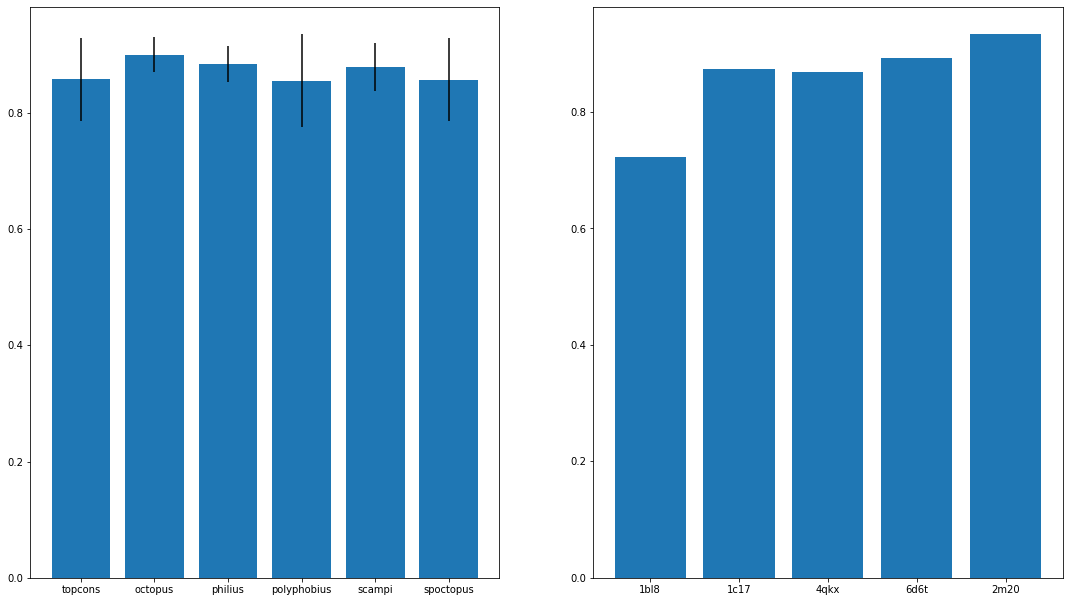

In [3]:
#load topcons predictions
prediction_methods = ["topcons", "octopus", "philius", "polyphobius", "scampi", "spoctopus"]
topcons_preds = {}
method_accuracies = {}
avg_accuracies = {}
std_accuracies = {}
seq_lengths = {}
for m in prediction_methods:
    topcons_preds[m] = {}
    method_accuracies[m] = {}
    avg_accuracies[m] = 0
    std_accuracies[m] = 0

#get topcons predictions from file
for i in alpha_ids:
    topcons_file = open(topcons_pred_directory + i + ".txt")
    next_type = "none"
    for line in topcons_file:
        if "TOPCONS2" in line or "Generated" in line or "reliability" in line:
            continue
        if next_type != "none":
            topcons_preds[next_type][i] = line.replace("\n","")
            next_type = "none"
        for m in prediction_methods:
            if m in line.lower():
                next_type = m
    seq_lengths[i] = len(topcons_preds["topcons"][i])
                
#get values from xml files
pdbtm_structs = {}
for i in alpha_ids:
    struct_seq = ""
    xml_fname = xml_directory + i + ".xml"
    tree = ET.parse(xml_fname)
    root = tree.getroot()
    for child in root:
        if "CHAINID" in child.attrib and child.attrib['CHAINID']== 'A':
            chain_tree = child
    first = True
    for child in chain_tree:
        if "seq_beg" not in child.attrib:
            continue
        seq_beg = int(child.attrib["seq_beg"])
        seq_end = int(child.attrib["seq_end"])
        struct_type = child.attrib["type"]
        if first and seq_beg != 1:
            for index in range(1, seq_beg):
                struct_seq += "U"
            
        first = False
        for index in range(seq_beg, seq_end+1):
            struct_seq += struct_type
    for index in range(seq_end, seq_lengths[i]):
        struct_seq += "U"
    pdbtm_structs[i]  = struct_seq
            
        
#calculate total and individual structure accuracies
#because topcons and pdb tm use different annotation types, we will calculate accuracy on if topcons corrected predicted a helix (H)or non-helix (N)

#determine accuracy for each method and protein, fill in the metod_accuracy dictionary
for m in method_accuracies:
    for i in alpha_ids:
        pred_seq = topcons_preds[m][i].replace("S","N").replace("i","N").replace("o","N").replace("M","H")
        pdbtm_seq = pdbtm_structs[i].replace("1", "N").replace("2", "N").replace("L", "N").replace("F","N")
        matches = 0
        total = 0
        for (x,y) in zip(pred_seq, pdbtm_seq):
            if y == "U":
                continue
            total += 1
            if x == y:
                matches +=1
        method_accuracies[m][i] = matches/total

#average accuracies
for m in method_accuracies:
    avg_accuracies[m] = np.average(list(method_accuracies[m].values()))
    std_accuracies[m] = np.std(list(method_accuracies[m].values()))

#make bar graphs
figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18.5, 10.5)
axes[0].bar(avg_accuracies.keys(),avg_accuracies.values(),yerr=std_accuracies.values())
axes[1].bar(method_accuracies["topcons"].keys(),method_accuracies["topcons"].values())

# Analysis of amino acid preference
We will analyze the amino acid distribution for four types of structures:
- not membrane associated
- TM Helix
- TM beta bundle
- Membrane loop (loop that dips into the membrane)
- Interfacial helix (helix close to but not inside membrane)

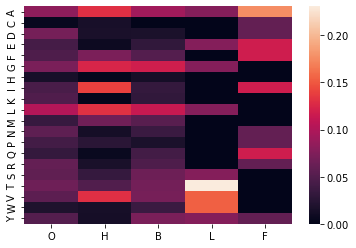

In [4]:
all_ids = alpha_ids + beta_ids
types = ["O", "H", "B", "L", "F"]
aas= ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P","Q", "R", "S", "T", "V", "W", "Y"]
aas_by_type = {}
for t in types:
    aas_by_type[t] = {}
    for a in aas:
        aas_by_type[t][a] = 0
    

for i in all_ids:
    chain_trees = []
    xml_fname = xml_directory + i + ".xml"
    tree = ET.parse(xml_fname)
    root = tree.getroot()
    for child in root:
        if "CHAINID" in child.attrib:
            seq = ""
            chain_tree = child
            for child in chain_tree:
                if "SEQ" in child.tag:
                    seq = child.text.replace(" ", "").replace("\n", "")
                    continue
                    
                seq_beg = int(child.attrib["seq_beg"])
                seq_end = int(child.attrib["seq_end"])
                struct_type = child.attrib["type"]
                
                #replace 1 and 2 with O for outside membrane
                if struct_type == "1" or struct_type == "2":
                    struct_type = "O"
                
                if struct_type not in types:
                    continue
                
                sub_seq = seq[seq_beg-1:seq_end] 
                for c in sub_seq:
                    if c not in aas:
                        continue
                    aas_by_type[struct_type][c] += 1

#calculate frequency of each amino acid for each type
for t in aas_by_type:
    total_aas = np.sum(list(aas_by_type[t].values()))
    for a in aas_by_type[t]:
        aas_by_type[t][a] /= total_aas

data = {'col_1': types, 'col_2': aas}
df = pd.DataFrame.from_dict(aas_by_type)

#display heatmap
sns.heatmap(df);